# Barplots - correlations on test

In [4]:
import os
import anndata
import crested
import keras
import numpy as np
import warnings
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# Comprehensive TensorFlow/XLA warning suppression
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['XLA_FLAGS'] = '--xla_hlo_profile=false --xla_dump_to=/tmp/xla_dumps'
os.environ['CUDA_VISIBLE_DEVICES'] = os.environ.get('CUDA_VISIBLE_DEVICES', '0')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Suppress all warnings
warnings.filterwarnings('ignore')

# Additional TensorFlow configuration
tf.config.experimental.enable_op_determinism()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2025-07-28 16:50:28.637345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 16:50:28.662036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753714228.679668 2053766 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753714228.684930 2053766 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753714228.700202 2053766 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
data_files_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas"
checkpoint_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned"
experiment = "allcells_36kreads"
k_folds = 10
genome_path = "../../../../../../../data/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"
consensus_regions_file = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/consensus_regions_mouse_cleanup_annot_all_data_fulldepth.bed"

In [6]:
genome = crested.Genome(genome_path, name="mm10")
crested.register_genome(genome)

2025-07-28T16:50:42.320818+0200 INFO Genome mm10 registered.


In [ ]:
experiments = ["allcells_allreads", "allcells_36kreads", "limitedcells_allreads", "limitedcells_36kreads"]
technologies = ["10x", "hydrop"]

# Model paths organized by technology, experiment
# note, we're storing all anndata paths, but in reality we're only testing on the "all cells, all reads" scenarios
model_paths = {}
anndata_paths = {}
for tech in technologies:
    anndata_paths[tech] = {}
    model_paths[tech] = {}
    for exp in experiments:
        folder_name = f"{tech}_{exp}"
        model_paths[tech][exp] = f"{checkpoint_root}/{folder_name}/"
        anndata_paths[tech][exp] = f"{data_files_root}/{folder_name}/normalized_specific.h5ad"
        if not os.path.exists(model_paths[tech][exp]):
            raise FileNotFoundError(f"Model path does not exist: {model_paths[tech][exp]}")
        if not os.path.exists(anndata_paths[tech][exp]):
            raise FileNotFoundError(f"Anndata path does not exist: {anndata_paths[tech][exp]}")

print(f"Model folder path example: {model_paths['10x']['allcells_36kreads']}")
print(f"Anndata path example: {anndata_paths['hydrop']['limitedcells_allreads']}")

Model folder path example: ../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned/10x_allcells_36kreads/
Anndata path example: ../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas/hydrop_limitedcells_allreads/normalized_specific.h5ad


In [8]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # Changed from spearmanr to pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_validation_metrics(tech, exp, n_folds=10):
    """
    Compute validation metrics (correlations, MSE, loss) between predictions and ground truth 
    for validation set across all folds for a given technology and experiment.
    
    We always test on the "allcells allreads" scenario, since we want to know if models trained on worse data can still reach similar "good conclusions".

    Parameters:
    - tech: Technology ("10x" or "hydrop")
    - exp: Experiment name
    - model_type: "baseline" or "finetune"
    - n_folds: Number of folds (default 10)
    
    Returns:
    - Dictionary with correlations, mse_values, and loss_values for each fold
    """
    # Load anndata
    # !test all on the allcells_allreads test data!
    adata_path = anndata_paths[tech]["allcells_allreads"]
    adata = anndata.read_h5ad(adata_path)
    
    # Load models (suppress loading output)
    model_dir = model_paths[tech][exp]
    models = []
    for fold in range(n_folds):
        model_path = os.path.join(model_dir, f"fold_{fold}.keras")
        # Redirect stderr/stdout during model loading
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            model = keras.models.load_model(model_path, compile=False)
        models.append(model)
    
    # assert all models same n params
    n_params = [model.count_params() for model in models]
    if len(set(n_params)) != 1:
        raise ValueError("Not all models have the same number of parameters.")

    # Initialize the loss function used during training
    loss_fn = crested.tl.losses.CosineMSELogLoss(max_weight=1.0)

    correlations = []
    mse_values = []
    loss_values = []
    
    for fold in range(n_folds):
        # Get validation regions for this fold
        val_mask = adata.var[f"fold_{fold}"] == "val"
        val_regions = adata.var[val_mask].index.tolist()
        
        # Get ground truth for validation regions
        ground_truth = adata.X[:, val_mask].T  # Shape: (n_regions, n_celltypes)
        
        # Get predictions (completely suppress all output)
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            predictions = crested.tl.predict(
                input=val_regions,
                model=models[fold],
                verbose=0
            )
        
        # Compute correlation for each cell type and average
        fold_correlations = []
        for celltype_idx in range(ground_truth.shape[1]):
            corr, _ = pearsonr(ground_truth[:, celltype_idx], predictions[:, celltype_idx])
            if not np.isnan(corr):
                fold_correlations.append(corr)
        
        # Average correlation across cell types for this fold
        avg_correlation = np.mean(fold_correlations) if fold_correlations else 0
        correlations.append(avg_correlation)
        
        # Compute MSE (mean across all cell types and regions)
        mse = mean_squared_error(ground_truth.flatten(), predictions.flatten())
        mse_values.append(mse)
        
        # Compute validation loss using CosineMSELogLoss
        val_loss = loss_fn(ground_truth.astype(np.float32), predictions.astype(np.float32))
        if hasattr(val_loss, 'numpy'):
            val_loss = val_loss.numpy()
        if isinstance(val_loss, np.ndarray):
            val_loss = np.mean(val_loss)
        loss_values.append(float(val_loss))
        print(f"Fold {fold}: Corr={avg_correlation:.4f}, MSE={mse:.6f}, Loss={val_loss:.6f}")
    
    return {
        'correlations': correlations,
        'mse_values': mse_values,
        'loss_values': loss_values
    }

In [9]:
def plot_correlation_comparison(correlation_results, figsize=(10, 6)):
    """
    Create a grouped bar chart comparing validation Pearson correlations
    between technologies across experiments.
    
    Parameters:
    - correlation_results: Dictionary with structure {tech: {exp: [correlations]}}
    - figsize: Figure size tuple
    """
    # Prepare data for plotting
    exp_labels = []
    tech_10x_means = []
    tech_10x_stds = []
    tech_hydrop_means = []
    tech_hydrop_stds = []
    
    for exp in experiments:
        exp_labels.append(exp.replace('_', '\n'))  # Line break for better readability
        
        # 10x results
        corrs_10x = correlation_results['10x'][exp]
        tech_10x_means.append(np.mean(corrs_10x))
        tech_10x_stds.append(np.std(corrs_10x))
        
        # Hydrop results
        corrs_hydrop = correlation_results['hydrop'][exp]
        tech_hydrop_means.append(np.mean(corrs_hydrop))
        tech_hydrop_stds.append(np.std(corrs_hydrop))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(exp_labels))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, tech_10x_means, width, yerr=tech_10x_stds, 
                   label='10x', capsize=5, alpha=0.8, color='#0072B2')
    bars2 = ax.bar(x + width/2, tech_hydrop_means, width, yerr=tech_hydrop_stds, 
                   label='Hydropv2', capsize=5, alpha=0.8, color='#E69F00')
    
    # Customize the plot
    ax.set_ylabel('Test Pearson Correlation', fontsize=12)
    ax.set_title('Model Performance Comparison: 10x vs Hydropv2\n(Finetuned Models)', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(exp_labels)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_value_labels(bars, means, stds):
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=10)
    
    add_value_labels(bars1, tech_10x_means, tech_10x_stds)
    add_value_labels(bars2, tech_hydrop_means, tech_hydrop_stds)
    
    plt.tight_layout()
    return fig, ax

In [10]:
# Compute validation metrics for all experiments (finetune models only)
validation_results = {}

for tech in technologies:
    validation_results[tech] = {}
    
    for exp in experiments:
        print(f"Processing {tech} {exp}...")
        try:
            metrics = compute_validation_metrics(tech, exp)
            validation_results[tech][exp] = metrics
        except Exception as e:
            print(f"Error processing {tech} {exp}: {e}")
            validation_results[tech][exp] = {
                'correlations': [0] * 10,
                'mse_values': [0] * 10, 
                'loss_values': [0] * 10
            }  # Fallback

correlation_results = {}
for tech in technologies:
    correlation_results[tech] = {}
    for exp in experiments:
        correlation_results[tech][exp] = validation_results[tech][exp]['correlations']

Processing 10x allcells_allreads...


I0000 00:00:1753714282.665829 2053766 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
I0000 00:00:1753714286.801061 2056147 cuda_dnn.cc:529] Loaded cuDNN version 90300


Fold 0: Corr=0.5097, MSE=0.039633, Loss=1.506857
Fold 1: Corr=0.4970, MSE=0.040892, Loss=1.511302
Fold 2: Corr=0.5361, MSE=0.061118, Loss=1.412168
Fold 3: Corr=0.6158, MSE=0.081780, Loss=1.251068
Fold 4: Corr=0.7024, MSE=0.263659, Loss=1.083812
Fold 5: Corr=0.6840, MSE=0.217161, Loss=0.899958
Fold 6: Corr=0.6662, MSE=0.183737, Loss=0.918445
Fold 7: Corr=0.6258, MSE=0.124385, Loss=1.013186
Fold 8: Corr=0.6547, MSE=0.121369, Loss=0.971019
Fold 9: Corr=0.6173, MSE=0.144209, Loss=1.116618
Processing 10x allcells_36kreads...
Fold 0: Corr=0.4607, MSE=0.036063, Loss=1.752212
Fold 1: Corr=0.4740, MSE=0.051001, Loss=1.711916
Fold 2: Corr=0.5117, MSE=0.063773, Loss=1.484406
Fold 3: Corr=0.5831, MSE=0.091458, Loss=1.476528
Fold 4: Corr=0.7028, MSE=0.271021, Loss=1.249303
Fold 5: Corr=0.6942, MSE=0.247364, Loss=1.236449
Fold 6: Corr=0.6577, MSE=0.210223, Loss=1.207049
Fold 7: Corr=0.6130, MSE=0.152673, Loss=1.390921
Fold 8: Corr=0.6365, MSE=0.131349, Loss=1.329439
Fold 9: Corr=0.5515, MSE=0.180753

In [6]:
# Compute validation metrics for all experiments (finetune models only)
validation_results = {}

for tech in technologies:
    validation_results[tech] = {}
    
    for exp in experiments:
        print(f"Processing {tech} {exp}...")
        try:
            metrics = compute_validation_metrics(tech, exp, model_type="finetune")
            validation_results[tech][exp] = metrics
        except Exception as e:
            print(f"Error processing {tech} {exp}: {e}")
            validation_results[tech][exp] = {
                'correlations': [0] * 10,
                'mse_values': [0] * 10, 
                'loss_values': [0] * 10
            }  # Fallback

# Keep backward compatibility for correlation_results
correlation_results = {}
for tech in technologies:
    correlation_results[tech] = {}
    for exp in experiments:
        correlation_results[tech][exp] = validation_results[tech][exp]['correlations']

Processing 10x allcells_allreads...


I0000 00:00:1750937967.728359  610364 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
I0000 00:00:1750937972.849374  610532 cuda_dnn.cc:529] Loaded cuDNN version 90300


Fold 0: Corr=0.5097, MSE=0.039633, Loss=1.506857
Fold 1: Corr=0.4970, MSE=0.040892, Loss=1.511302
Fold 2: Corr=0.5361, MSE=0.061118, Loss=1.412168
Fold 3: Corr=0.6158, MSE=0.081780, Loss=1.251068
Fold 4: Corr=0.7024, MSE=0.263659, Loss=1.083812
Fold 5: Corr=0.6840, MSE=0.217161, Loss=0.899958
Fold 6: Corr=0.6662, MSE=0.183737, Loss=0.918445
Fold 7: Corr=0.6258, MSE=0.124385, Loss=1.013186
Fold 8: Corr=0.6547, MSE=0.121369, Loss=0.971019
Fold 9: Corr=0.6173, MSE=0.144209, Loss=1.116618
Processing 10x allcells_36kreads...
Fold 0: Corr=0.4483, MSE=0.032975, Loss=2.160960
Fold 1: Corr=0.4567, MSE=0.047963, Loss=2.131384
Fold 2: Corr=0.4888, MSE=0.059514, Loss=2.000329
Fold 3: Corr=0.5659, MSE=0.090408, Loss=1.973251
Fold 4: Corr=0.6888, MSE=0.268133, Loss=1.611398
Fold 5: Corr=0.6886, MSE=0.238894, Loss=1.541853
Fold 6: Corr=0.6484, MSE=0.198350, Loss=1.540204
Fold 7: Corr=0.6058, MSE=0.152925, Loss=1.681783
Fold 8: Corr=0.6280, MSE=0.122534, Loss=1.623874
Fold 9: Corr=0.5333, MSE=0.159998

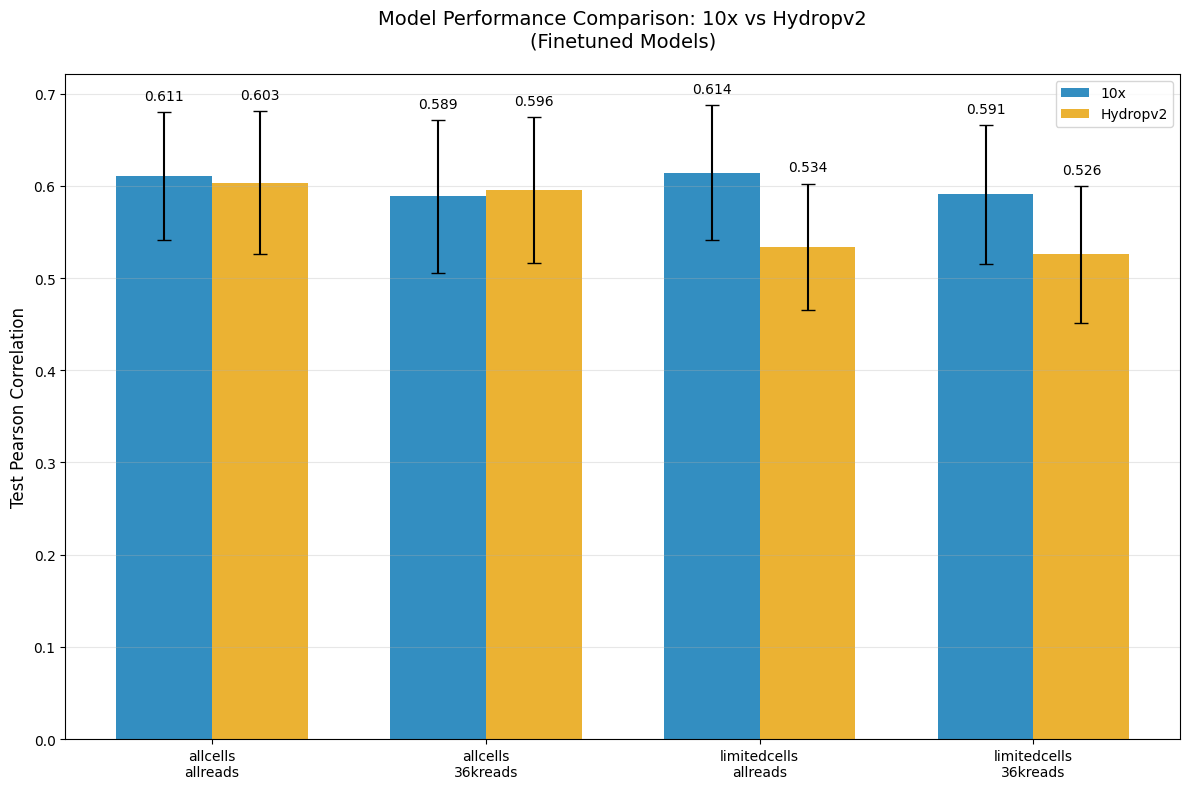

In [13]:
%matplotlib inline
# Create the grouped bar chart
fig, ax = plot_correlation_comparison(correlation_results, figsize=(12, 8))
plt.show()

In [14]:
# save as editable pdf
fig.savefig("../../../plots/correlation_barplots_comparisons.pdf", bbox_inches='tight', format='pdf', dpi=400)